$\eta$ analysis
============
This notebook presents my $\eta$ analysis of the 2016 UT testbeam data.

First problem. 
---------
There is no angle scan data for big sensors. That kind fo study was not performed. 

So I decided to use minisensor's data. 


In [4]:
import root_numpy
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import ROOT
%matplotlib inline

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

Grab data from ntuple
================== 

In [5]:
root_file = ROOT.TFile("datasets/Run_Angle_Scan-M1-FanIn-110-15054_Tracks.root")
tree = root_file.Get("Clusters")

In [6]:
tree.Print()

******************************************************************************
*Tree    :Clusters  : TbUT nTuple                                            *
*Entries :   900000 : Total =       696803342 bytes  File  Size =  175280907 *
*        :          : Tree compression factor =   3.93                       *
******************************************************************************
*Br    0 :clusterNumberPerEvent : clusterNumberPerEvent/I                    *
*Entries :   900000 : Total  Size=    3601410 bytes  File Size  =     530680 *
*Baskets :        7 : Basket Size=    1434624 bytes  Compression=   6.16     *
*............................................................................*
*Br    1 :clustersTDC : clustersTDC/i                                        *
*Entries :   900000 : Total  Size=    3601280 bytes  File Size  =     682748 *
*Baskets :        7 : Basket Size=    1434624 bytes  Compression=   4.79     *
*...................................................

Find the beam region
-------------

In [7]:
c = ROOT.TCanvas("Position","seed position",800,600)
tree.Draw("clustersPosition")
ROOT.enableJSVis()
c.Draw()

The strips in beam region has numbers between 410 and 440

Now plot charge distribution of the 2 seeds clusters. 
------------
I grab only clusters from the beam region.  

In [8]:
cut = "clustersPosition>410 && clustersPosition<440 && clustersSize == 2"

In [9]:
c = ROOT.TCanvas("charge","charge",800,600)
tree.Draw("clustersCharge",cut)
c.Draw()

Number of clusters after the very first selection is $1.8 \times 10^5$ 
--------
It is an order of magnitude less than we assumed.

Convert Root Tree into pandas data frame.
----------
It is easier to manipulate df instead of root. 
I need to do it manualy due to structures of the tree. 
The usual function root_numpy.tree2array doesn't work. 
 
 For now I grab only 2 strips clusters. 

In [ ]:
charge = []
seed_charge = []
left_charge = [] 
right_charge = [] 
position = []
seed_position = []

print (tree.GetEntries())

for entry in range(tree.GetEntries()):
    if(entry % 10000 == 0):
        print ("entry%d"%entry)
    tree.GetEntry(entry)
    if tree.clusterNumberPerEvent == 0 :
        continue
    clusterNumber = min(5, tree.clusterNumberPerEvent)
    for clusterIt in range(clusterNumber):
        if(tree.clustersSize[clusterIt] != 2):
            continue
        charge.append(tree.clustersCharge[clusterIt])
        seed_charge.append(tree.clustersSeedCharge[clusterIt])
        left_charge.append(tree.clustersCharge1StripLeft[clusterIt])
        right_charge.append(tree.clustersCharge1StripRight[clusterIt])
        position.append(tree.clustersPosition[clusterIt])
        seed_position.append(tree.clustersSeedPosition[clusterIt])    

In [49]:
tmp_dictionary = {"charge":charge, 
                  "seed_charge":seed_charge,
                  "left_charge":left_charge, 
                  "right_charge":right_charge,
                  "position":position,
                  "seed_position":seed_position
}
data = pd.DataFrame(tmp_dictionary)
data.head()

,charge,left_charge,position,right_charge,seed_charge,seed_position
0,535.838710,54.419355,421.898441,28.419355,481.419355,422
1,514.785322,43.392661,416.915707,10.392661,471.392661,417
2,647.780895,66.390448,430.897511,-1.609552,581.390448,431
3,383.063664,51.531832,416.865474,18.531832,331.531832,417
4,78.555844,-1.722078,393.436351,34.277922,44.277922,393


In [71]:
def print_histogram(data, label, xlabel, ylabel):
    hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
    fig = plt.figure(figsize=(6,6))
    min_value, max_value = numpy.percentile(data, [1, 99])
    plt.hist(data.values, range=(min_value, max_value), 
            label=label,  **hist_params)
    plt.xlabel('cluster charge [ADC]')

    plt.legend(loc='best');

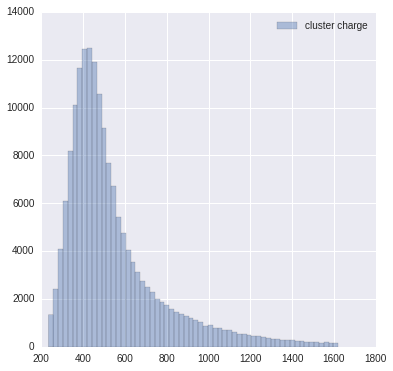

In [72]:
cluster_charge = data.charge[(data.position>410)&(data.position<440)]
print_histogram(cluster_charge,"cluster charge")

In [50]:
cluster_number = len(data.charge[(data.position>410)&(data.position<440)].values)
print("Number of clusters in the beam region %d"% cluster_number)

Number of clusters in the beam region 173310


Add to data couple of columns.
-------------
One of them contains position of the second strip (is it situated left or right from the seed strip).
The second one contain secodn strip charge. 
I need to verify if the sum of the charges (secodn and seed) is equal to the cluster charge.

In [51]:
data["is_second_right"] = (data.seed_position -data.position) <0 
data["second_charge"] = numpy.where(data.is_second_right, data.right_charge, data.left_charge)
data["check"] = data.charge-data.second_charge - data.seed_charge

Calcualte $\eta$
===============

I calculate eta using following formula $\eta = \frac{Q_1}{Q_1+Q_2}$

Where: 
* $Q_1$ - charge of left strip
* $Q_2$ - charge of right strip

I also look at the distribution of the cluster charge assymetries. It looks weird!

In [57]:
data["eta"] = numpy.where(data.is_second_right, data.second_charge/data.charge , data.seed_charge/data.charge)

In [58]:
data.head()

,charge,left_charge,position,right_charge,seed_charge,seed_position,is_second_right,second_charge,check,eta
0,535.838710,54.419355,421.898441,28.419355,481.419355,422,False,54.419355,0,0.898441
1,514.785322,43.392661,416.915707,10.392661,471.392661,417,False,43.392661,0,0.915707
2,647.780895,66.390448,430.897511,-1.609552,581.390448,431,False,66.390448,0,0.897511
3,383.063664,51.531832,416.865474,18.531832,331.531832,417,False,51.531832,0,0.865474
4,78.555844,-1.722078,393.436351,34.277922,44.277922,393,True,34.277922,0,0.436351


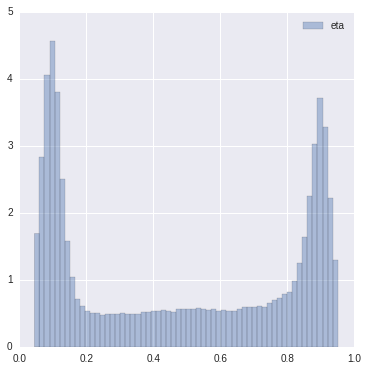

In [66]:
good_eta = data.eta[(data.position>410)&(data.position<440)] 
print_histogram(good_eta, "eta")

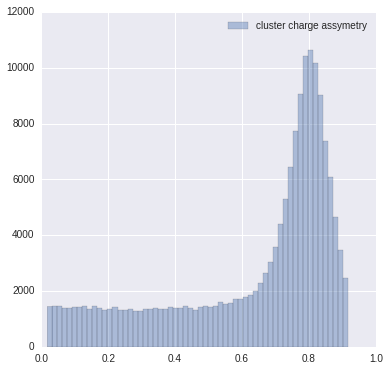

In [73]:
assymetry = abs(data.seed_charge[(data.position>410)&(data.position<440)] -
                data.second_charge[(data.position>410)&(data.position<440)])\
                / data.charge[(data.position>410)&(data.position<440)]
print_histogram(assymetry, "cluster charge assymetry")

Now I need to figure out how to get track position. It is quite hard.